In [1]:
r"""
Self-supervised learning with Generalized Recorrupted-to-Recovered (GR2R) 

Gaussian Denoising Example
====================================================================================================

This example shows you how to train a reconstruction network for an denoising problem on a fully self-supervised way, i.e., using corrupted measurement data only.
"""

import os
import deepinv as dinv
from torch.utils.data import DataLoader
import torchvision
import torch
import numpy as np
from pathlib import Path
from torchvision import transforms
from deepinv.optim.prior import PnP
from deepinv.utils.demo import load_dataset, load_degradation
import wandb
import argparse
from torch.utils.data import DataLoader, random_split
from deepinv.loss import PSNR, SSIM, Loss, SupLoss
import matplotlib.pyplot as plt



/home/bemc/miniconda3/envs/deepinv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_weights_url(file_name):
    return (
        "https://huggingface.co/bemc22/"
        + "GeneralizedR2R"
        + "/resolve/main/"
        + file_name
        + "?download=true"
    )

In [3]:
# ---------------------------------------------------------------
# Setup paths for data loading and results.
# ---------------------------------------------------------------

BASE_DIR = Path(".")
PROJECT_NAME = "mri-gaussian-denoising"
ORIGINAL_DATA_DIR =  Path("./data")
DATA_DIR = ORIGINAL_DATA_DIR / "measurements"
RESULTS_DIR = BASE_DIR / "results"
DEG_DIR = BASE_DIR / "degradations"
CKPT_DIR = BASE_DIR / "ckpts" / PROJECT_NAME

# Set the global random seed from pytorch to ensure reproducibility of the example.
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

Selected GPU 0 with 22722 MB free memory 


In [4]:
def run(args, batch_id=0, weights_id=0):
    # print  all the arguments
    trial_id = args.trial
    torch.manual_seed(trial_id)

    run_name = f"{args.loss}-{args.noise}"

    wandb_setup = {
        "project": PROJECT_NAME,
        "config": args,
        "name": run_name,
    }


    # # ----------------------------------------------------------------------------------
    # Generate a dataset of knee images and load it.
    # ----------------------------------------------------------------------------------

    physics = dinv.physics.Denoising(noise_model=dinv.physics.GaussianNoise(args.noise))

            
    # Use parallel dataloader if using a GPU to fasten training,
    # otherwise, as all computes are on CPU, use synchronous data loading.
    num_workers = 4 if torch.cuda.is_available() else 0
    n_images_max = (
        900 if torch.cuda.is_available() else 5
    )  # number of images used for training
    # (the dataset has up to 973 images, however here we use only 900)

    
    # ----------------------------------------------------------------------------------
    # Generate a dataset of knee images and load it.
    # ----------------------------------------------------------------------------------
    my_dataset_name = "mri_gaussian_denoising"
    operation = f"Denoising_{args.noise}"
    train_dataset_name = "fastmri_knee_singlecoil"
    measurement_dir = DATA_DIR / train_dataset_name / operation

    if not os.path.exists(measurement_dir / f"{my_dataset_name}0.h5"):

        img_size = 256

        transform = transforms.Compose([transforms.Resize(img_size)])

        train_dataset = load_dataset(
            train_dataset_name, ORIGINAL_DATA_DIR, transform, train=True
        )
        test_dataset = load_dataset(
            train_dataset_name, ORIGINAL_DATA_DIR, transform, train=False
        )

        deepinv_datasets_path = dinv.datasets.generate_dataset(
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        physics=physics,
        device=device,
        save_dir=measurement_dir,
        train_datapoints=n_images_max,
        num_workers=num_workers,
        dataset_filename=str(my_dataset_name),
        )

    else:
        deepinv_datasets_path = measurement_dir / f"{my_dataset_name}0.h5"

    
    train_dataset = dinv.datasets.HDF5Dataset(path=deepinv_datasets_path, train=True)
    test_dataset = dinv.datasets.HDF5Dataset(path=deepinv_datasets_path, train=False)

    
    # Set up the reconstruction network
    # ---------------------------------------------------------------
    #
    # As a reconstruction network, we use an unrolled network (half-quadratic splitting)
    # with a trainable denoising prior based on the DnCNN architecture.

    n_channels = 2  # real + imaginary parts
    # Define the unfolded trainable model.

    model = dinv.models.DnCNN(   in_channels=n_channels,
                                 out_channels=n_channels,
                                 pretrained=None,
                                 depth=7,
                                 train=True,
                                 last_act=None,
                                 residual=True).to(device)
 
    # Set up the training parameters
    # --------------------------------------------

    noise_level   = args.noise
    

    if args.loss == "sup":   # SUPERVISED LOSS
        loss = dinv.loss.SupLoss()

    elif args.loss == "gr2r": # EQUIVARIANT RECORRUPTED LOSS
        r2r_loss = dinv.loss.R2RLoss(sigma=noise_level, alpha=args.alpha)
        loss     = [ r2r_loss ]
        model    = r2r_loss.adapt_model(model, MC_samples=20) # important step!

    if args.loss == "neigh": # NEIGHBORHOOD LOSS

        neigh_loss = dinv.loss.Neighbor2Neighbor()
        loss = [ neigh_loss ]

    test_dataloader = DataLoader(
        test_dataset, batch_size=1, num_workers=num_workers, shuffle=False
    )

    save_path = Path(CKPT_DIR / f"noise={args.noise}"  / args.loss )
    weights_path = os.listdir(save_path)[weights_id]
    tmp_weights_path = os.path.join(save_path, weights_path, "ckp_last.pth.tar")
    model.load_state_dict(torch.load(tmp_weights_path)["state_dict"])

    model.eval()

    logs = {}

    for iter, batch in enumerate(test_dataloader):

        if iter != batch_id:
            continue

        x, y = batch

        x = x.to(device)
        y = y.to(device)

        x_net = model(y, physics)
        
        psnr_val =  PSNR()(x=x, x_net=x_net, y=y, physics=physics).item()
        ssim_val = SSIM()(x=x, x_net=x_net, y=y, physics=physics).item()

        logs["x_est"] = x_net
        logs["psnr"] = psnr_val
        logs["ssim"] = ssim_val
    
    print(args.loss, args.noise, logs["psnr"], logs["ssim"])
    
    return logs, x, y

In [5]:
class Args:
    loss        = "gr2r"
    noise       = 0.1
    trial       = 0
    alpha       = 0.2

args = Args()

gr2r 0.1 33.20705795288086 0.9331914132488923


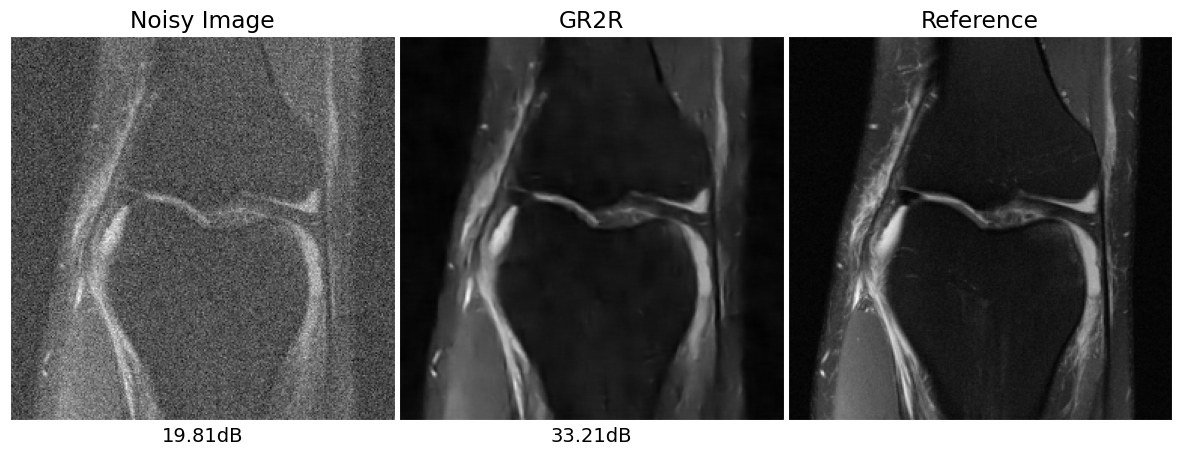

gr2r 0.1 30.32270050048828 0.8338793989204455


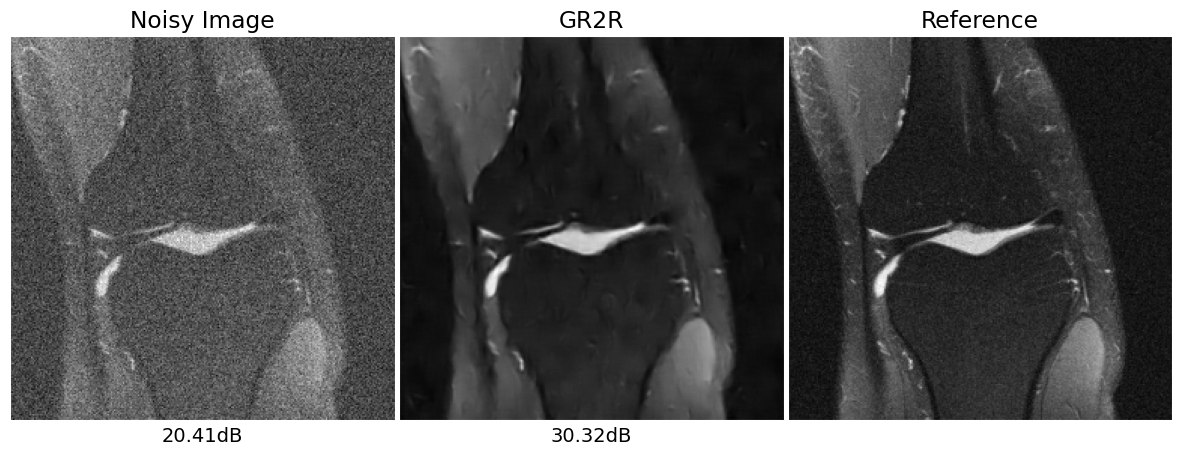

gr2r 0.1 31.92619514465332 0.9110836559679732


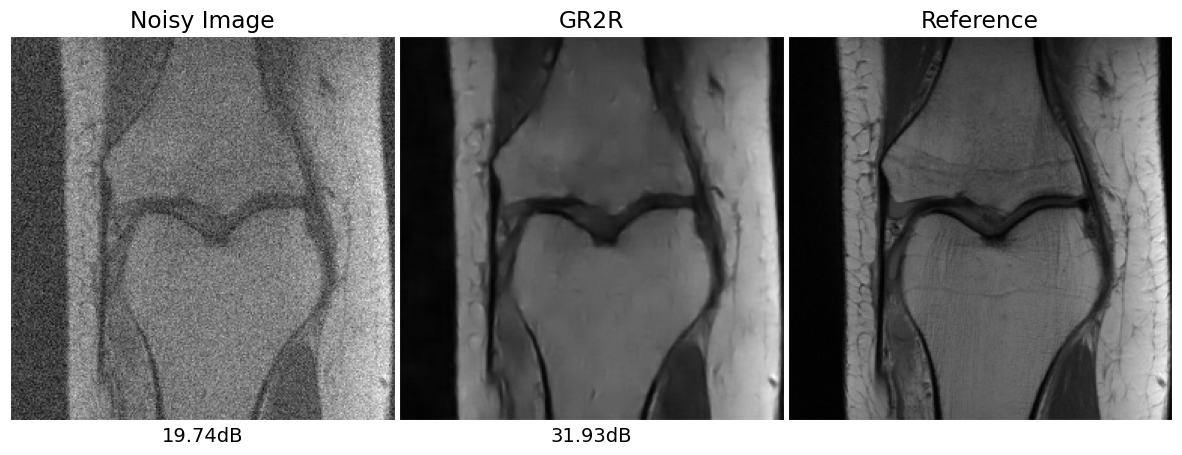

gr2r 0.1 31.13459587097168 0.8589301883428908


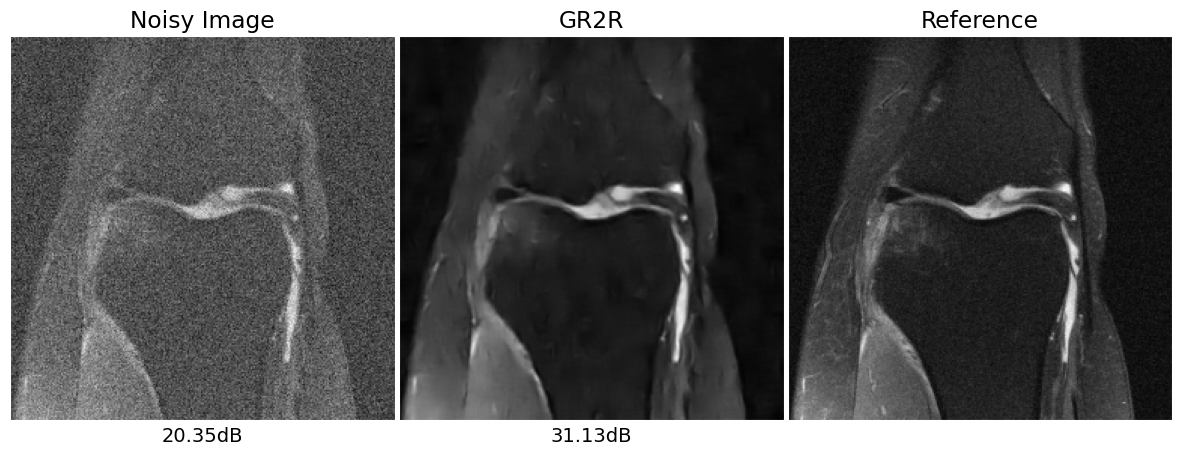

gr2r 0.1 34.34469985961914 0.9299777293309736


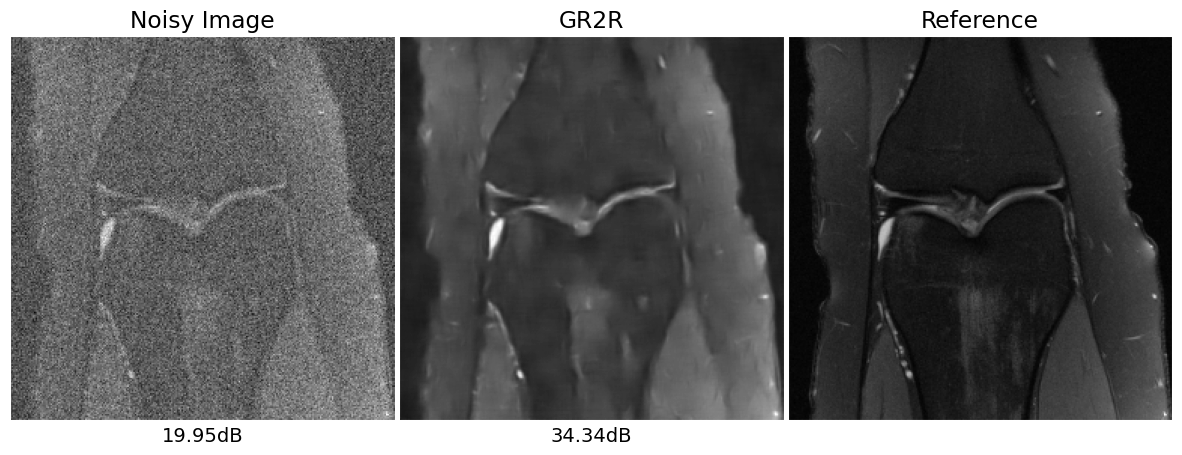

In [6]:
for kk in range(5):
    batch_id = kk 

    loss = [ 
        ["gr2r", -1],
    ]

    # set fontsize 
    plt.rcParams['text.usetex'] = False
    # change font size
    plt.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots(1, len(loss) + 2, figsize=(15, 5))
    plot_title = True

    for j, l in enumerate(loss):
        loss_name =  l[0]
        args.loss = loss_name
        logs, x, y = run(args, batch_id, l[1])

        x_est = logs["x_est"].cpu().detach().numpy().squeeze()
        x_est = x_est.transpose(1, 2, 0)

        x_est = (x_est - x_est.min()) / (x_est.max() - x_est.min())
        x_est = x_est[::-1, ...]

        ax[j+1].imshow(x_est[..., 0], origin="lower", cmap="gray")

        ax[j+1].set_xlabel(f"{logs['psnr']:.2f}dB", c="black")
        if plot_title:

            if loss_name == "er":
                loss_name = "gr2r"

            ax[j+1].set_title(f"{loss_name.upper()}")
        ax[j+1].set_xticks([])
        ax[j+1].set_yticks([])

        # set image border in white
        for spine in ax[j+1].spines.values():
            spine.set_edgecolor('white')
    
    x_plot = x.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
    x_plot = (x_plot - x_plot.min()) / (x_plot.max() - x_plot.min())
    x_plot = x_plot[::-1, ...]

    ax[-1].imshow(x_plot[..., 0], origin="lower", cmap="gray")


    if plot_title:
        ax[-1].set_title("Reference")
    ax[-1].set_xticks([])
    ax[-1].set_yticks([])

    for spine in ax[-1].spines.values():
        spine.set_edgecolor('white')
    

    psnr_baseline = PSNR()(x_net=y, x=x).item()

    y_plot = y.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
    y_plot = y_plot[::-1, ...]
    ax[0].imshow(y_plot[..., 0], origin="lower", cmap="gray")


    if plot_title:
        ax[0].set_title("Noisy Image")
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_xlabel(f"{psnr_baseline:.2f}dB", c="black")

    for spine in ax[0].spines.values():
        spine.set_edgecolor('white')

    # reduce space between subplots
    plt.subplots_adjust(wspace=0.01, hspace=0.1)
    plt.show()